### Final Propensity matching results

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [40]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [7]:
%config Completer.use_jedi = False

### Load pre matching data

In [8]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2Past2.p ./Pre_Matching_DATA/treated2Past2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controlsPast.p ./Pre_Matching_DATA/controlsPast.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [10]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [11]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [12]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((22364, 92), 201710, 202107)

In [13]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 92), 201701, 202107)

In [14]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [15]:
def get_treated_agg(treated, pmpm):
    
    #get one year before dates
    treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
    treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
    treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, month_offset=12)
    
    treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
    for i, (index, row) in tqdm(enumerate(treated.iterrows())):
        pid = row.PERS_ID
        myr = row.MYR
        old_myr = row.MYR_12
        history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
        agg_data = history[col_seq_can_all].mean()
        agg_data.PERS_ID = str(int(row.PERS_ID))
        agg_data.MYR     = int(row.MYR)
        treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
    treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
    treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
    treated_aggregate = treated_aggregate.reset_index(drop=True)
    
    return treated_aggregate
    

In [16]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./FinalData/treated_aggregated_filtered_final_g.p")

In [17]:
# treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']] = treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']].apply(data_process.log_)

In [18]:
treated_aggregate = pd.read_pickle("./FinalData/treated_aggregated_filtered_final_g.p") #goes into matching as tr_agg

# Load Model and Pick Columns for Matching

In [19]:
model = models.load_model(pp_str+"TF_Latent_Model_m6_Canary_stacked_logfixed", compile=False)

In [20]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [21]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR', onset]

In [22]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

# Matching

In [23]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'tr_agg':treated_aggregate.copy(), 'pmpm':pmpm.copy(), 'latent_cols':latent_cols, 'model':model, 'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated.copy(), 
                                           controls2.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:269017 before they were:299160


0it [00:00, ?it/s]

IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None


1367it [1:07:58,  2.98s/it]


There were no matches for 0 out of 1367 patients
CPU times: user 1h 3min 39s, sys: 37min 19s, total: 1h 40min 59s
Wall time: 1h 8min 13s


In [25]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [28]:
controls_aggregate = get_data(matched0)

In [30]:
Path("./FinalData/NNB_ipfilter").mkdir(exist_ok=True)
p_data = "./FinalData/NNB_ipfilter/"

In [31]:
controls_aggregate.to_pickle(p_data+"matched_controls_aggregate.p")

In [163]:
matched_data0.shape, matched_data00.shape

In [162]:
matched_data0.to_pickle("./FinalData/NNB_ipfilter/matched_data0.p")

In [33]:
controls_all =  pd.DataFrame()
matched_data00 = pd.DataFrame()
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

In [34]:
%%time
counter = 0

for (key, month), val in matched0.items():
    val['RD'] = val.MYR
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)    
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    matched_data00 = pd.concat((matched_data00, new_dat2), ignore_index = True)
    controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    counter += 1

CPU times: user 6min 45s, sys: 1min 35s, total: 8min 21s
Wall time: 8min 21s


In [35]:
matched_data00.shape, controls_all.shape

In [36]:
matched_data00.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

In [38]:
matched_data00.to_pickle(p_data + "matched_controls_original.p")

In [39]:
controls_all.to_pickle(p_data + "controls_all_nouse.p")

In [47]:
treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']] = treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']].apply(data_process.log_)

In [49]:
treated_latent = pd.DataFrame(model.predict(treated_aggregate.loc[:,'AGE_AT_MIDMONTH':]), columns=latent_cols)
treated_latent.insert(0, 'PERS_ID', treated_aggregate.PERS_ID)
treated_latent.insert(1, 'MYR', treated_aggregate.MYR)

In [51]:
treated_latent.to_pickle(p_data+"treated_latent.p")

In [52]:
controls_latent = pd.DataFrame(model.predict(controls_aggregate.loc[:,'AGE_AT_MIDMONTH':]), columns=latent_cols)
controls_latent.insert(0, 'PERS_ID', controls_aggregate.PERS_ID)
controls_latent.insert(1, 'MYR', controls_aggregate.MYR)

In [54]:
controls_latent.to_pickle(p_data+"matched_controls_latent.p")

### List containing all numerical columns

In [42]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [ ]:
del controls, controls2

In [59]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data00, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 33s, sys: 7.15 s, total: 2min 40s
Wall time: 2min 40s


In [60]:
conds_first

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.738113        50.730335   0.021046  9.832092e-01          44.310976   47.606399
ALLOW_AMT        712.070227       643.654607   0.841176  4.002741e-01        1065.926022  648.802692
MBR_GNDR           0.212143         0.211953   0.015756  9.874295e-01           0.442749    0.431056
CC_TOBACCO         0.061448         0.085103  -2.924565  3.458834e-03           0.074202    0.098400
CC_PRESSURE        0.001463         0.002344  -0.634696  5.256443e-01           0.007390    0.006602
CC_OBESITY         0.498903         0.302036  14.249267  1.581027e-45           0.108841    0.228035
CC_HYPERTENSION    0.342356         0.251062   6.990188  2.960534e-12           0.207717    0.249365
CC_HYPOTHYROID     0.100951         0.085543   1.834640  6.659534e-02           0.047300    0.063484
CC_DX_CNT          2.912217         2.322250   9.398259  7.064212e-21           1.824419    2.343702
ACUTE2             0.039503         0.036033   0.595168  5.517477e-01           0.063258    0.051549
ACUTE6             0.115582         0.110151   0.460270  6.453345e-01           0.063258    0.153377
IP_BIN6            0.029993         0.026512   0.637622  5.237373e-01           0.020587    0.046851
ER_BIN6            0.091441         0.087007   0.430441  6.668860e-01           0.047286    0.116176
LOB                0.954645         0.955764  -0.183217  8.546324e-01           0.755775    0.787836

In [61]:
conds_first.to_csv("./Final/results/conds_original_first.csv", index=True, header=True)
full_first.to_csv("./Final/results/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv("./Final/results/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv("./Final/results/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [63]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(controls_latent, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.41 s, sys: 2.8 ms, total: 2.42 s
Wall time: 2.41 s


In [65]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [69]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 3.06 s, sys: 2.55 ms, total: 3.06 s
Wall time: 3.06 s


In [72]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                   mean             mean  t-stat   pval
AGE_AT_MIDMONTH  50.261           50.260   0.002  0.999
ALLOW_AMT         5.772            5.496   5.159  0.000
MBR_GNDR          0.212            0.218  -0.444  0.657
CC_TOBACCO        0.055            0.082  -3.618  0.000
CC_PRESSURE       0.001            0.002  -0.619  0.536
CC_OBESITY        0.442            0.278  13.006  0.000
CC_HYPERTENSION   0.320            0.236   7.112  0.000
CC_HYPOTHYROID    0.090            0.081   1.109  0.267
CC_DX_CNT         2.649            2.206   7.455  0.000
LOB               0.954            0.951   0.469  0.639

In [73]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [74]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data00[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 28.9 s, sys: 11.9 s, total: 40.8 s
Wall time: 40.8 s


In [76]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   51.079           51.474  -4.366  0.000             50.379   50.236
ALLOW_AMT        812.538          712.173   3.918  0.000            857.856  706.609
MBR_GNDR           0.196            0.197  -0.177  0.860              0.433    0.429
CC_TOBACCO         0.064            0.087 -11.104  0.000              0.102    0.100
CC_PRESSURE        0.003            0.003   0.175  0.861              0.013    0.008
CC_OBESITY         0.533            0.346  52.822  0.000              0.255    0.286
CC_HYPERTENSION    0.332            0.272  18.195  0.000              0.329    0.300
CC_HYPOTHYROID     0.098            0.090   3.640  0.000              0.078    0.075
CC_DX_CNT          3.049            2.558  29.900  0.000              2.955    2.759
ACUTE2             0.032            0.031   0.609  0.542              0.060    0.050
ACUTE6             0.101            0.096   1.756  0.079              0.168    0.150
IP_BIN6            0.026            0.027  -0.928  0.353              0.055    0.049
ER_BIN6            0.079            0.072   2.799  0.005              0.122    0.111
LOB                0.955            0.955   0.089  0.929              0.802    0.803

In [77]:
conds.to_csv("./Final/results/conds_original.csv", index=True, header=True)
full.to_csv("./Final/results/full_original.csv", index=True, header=True)
conds_AllCols.to_csv("./Final/results/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv("./Final/results/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [78]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = controls_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)
conds_latAllColsA, full_latAllColsA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)



CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 125 ms


In [82]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [83]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 406 ms, sys: 185 µs, total: 406 ms
Wall time: 405 ms


In [85]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [87]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [88]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [92]:
base_path =  './Final/results/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [89]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [90]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [93]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [94]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [126]:
controls = controls22[controls22.HasPast == 1].reset_index(drop=True)

In [96]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [97]:
con_desc0, controls_first_month = statistics_first_month(matched_data00, columns_to_match, return_array = True)

In [129]:
un_controls_ = controls[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [130]:
un_controls_all = controls[all_columns].describe().loc[['mean', 'std', 'count']].T

In [131]:
un_controls_all.to_csv("./Final/results/unmatched_all_cols_stats.csv", index=True, header=True)

In [133]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls))/(len(treated)+len(controls))

In [134]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

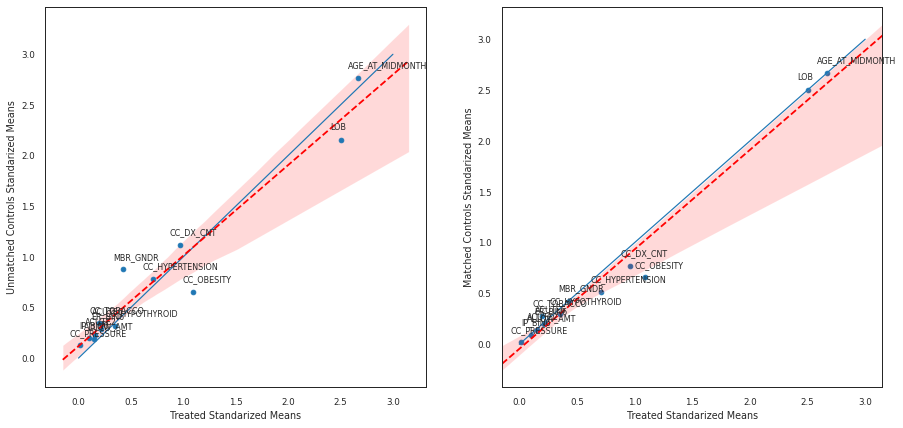

In [135]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig("./Final/results/std_means_graph.png")
fig.show()

# Ratio Stats

In [136]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [137]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [138]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [139]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated[[col]].values, controls[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated[[col]].values, controls[[col]].values)
        d_metric_before.loc[0,col] = d

In [140]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530245         0.097002   0.019605  0.007421  0.022341  0.036545      0.125552           0.208666  0.052351   0.061845             0.120749      0.004066   0.077408       0.155202   0.093986    0.029315  0.152525          0.070131     0.072633           0.016111           0.296291              0.048628  0.142301            0.028277       0.070755                 0.061908           0.055565     0.442922         0.132909   0.116793               0.013678     0.054364         0.004074     0.073625           0.073996          0.141028        0.014142              0.001615                 0.01887              0.024314                0.065728                     0.04492        0.005532        0.004006          0.068704          0.06133           0.139078         0.094408        0.027498      0.068358     0.193983        0.054986      0.012642  0.028972        0.048352     0.177813            0.061525               0.065677               0.030185    0.485391         0.087732   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  HasPast  
0       0.202588        0.004403     0.133835            0.100308  0.045762          0.087289                 0.12121        0.049591          0.00639   0.061889    0.153739            0.008892          0.047821  0.431702   0.033132  0.069914  0.065597  0.088439  0.065676  0.019829  0.002396  0.138117  0.114517  0.157056  0.092983  0.083748  0.113645  0.23801

In [141]:
d_metric_before.T.to_csv("./Final/results/d_metric_before.csv", header=True, index=True)

In [142]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

62

In [148]:
d1 = d_metric_before.loc[:,:'LOB']

In [150]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530245         0.097002   0.019605  0.007421  0.022341  0.036545      0.125552           0.208666  0.052351   0.061845             0.120749      0.004066   0.077408       0.155202   0.093986    0.029315  0.152525          0.070131     0.072633           0.016111           0.296291              0.048628  0.142301            0.028277       0.070755                 0.061908           0.055565     0.442922         0.132909   0.116793               0.013678     0.054364         0.004074     0.073625           0.073996          0.141028        0.014142              0.001615                 0.01887              0.024314                0.065728                     0.04492        0.005532        0.004006          0.068704          0.06133           0.139078         0.094408        0.027498      0.068358     0.193983        0.054986      0.012642  0.028972        0.048352     0.177813            0.061525               0.065677               0.030185    0.485391         0.087732   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.202588        0.004403     0.133835            0.100308  0.045762          0.087289                 0.12121        0.049591          0.00639   0.061889    0.153739            0.008892          0.047821  0.431702

In [151]:
d1.T[d1.T[0]<0.1].size

53

In [152]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated[[col]].values, matched_data00[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated[[col]].values, matched_data00[[col]].values)
        d_metric_after.loc[0,col] = d

In [157]:
d_metric_after.T.to_csv("./Final/results/d_metric_after.csv", header=True, index=True)

In [154]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

79

In [155]:
d2 = d_metric_after.loc[:,:'LOB']

In [156]:
d2.T[d2.T[0]<0.1].size

66

In [158]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.002461         0.331085   1.375273  2.104923  0.155335  2.110186      0.415241           0.421749  0.198644     0.5568             0.395373     12.999123   0.660733       0.113041   0.343558    0.806252  0.140448          0.365305     0.346831           1.412343           0.137212              1.002072  0.123296            0.330407       1.309491                 0.247164           0.656021     0.339149         0.008369   1.860098               0.281397     0.071688          1.89083     0.008531            0.00619           0.55851             NaN             18.521369                 0.08012                   NaN                0.323307                    0.159273             NaN             NaN          0.109927          0.55361           0.603683         1.396259        0.965325      0.702372     0.055552        0.336638      0.817449  1.531433        0.119727     0.514042            0.323293               0.526392                    NaN    0.790827         0.639477   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C    ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2   ACUTE2   HasPast  
0       0.116339        4.934418     0.009623            0.041438  1.889248          0.135001                0.287329        0.543985         2.061933   0.501908    0.556136            1.459603          0.349855  0.001528   0.626833  0.079269  0.090843  0.025671  1.337998  2.840011  30.891252  0.050184  0.170655  0.079605  0.079467  0.115851  0.03914  0.698519

In [159]:
ratio.T[ratio.T[0]>=1.0].size

19

In [160]:
ratio.T.to_csv("./Final/results/ratio.csv", header=True, index=True)